##### Copyright 2025 Google LLC.

In [23]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini API: Working with Charts, Graphs, and Slide Decks

Gemini models are powerful multimodal LLMs that can process both text and image inputs.

This notebook shows how Gemini Flash model is capable of extracting data from various images.

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Working_with_Charts_Graphs_and_Slide_Decks.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

In [24]:
%pip install -U -q "google-genai>=1.0.0"

In [25]:
import os
import time
from glob import glob

from PIL import Image
from IPython.display import Markdown, display

## Configure your API key

To run the following cell, your API key must be stored in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Authentication.ipynb) for an example.


In [26]:
from google import genai
from google.colab import userdata

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
client = genai.Client(api_key=GOOGLE_API_KEY)

## Setup
You will be using images from [Priyanka Vergadia's](https://github.com/priyankavergadia) [GCPSketchnote](https://github.com/priyankavergadia/GCPSketchnote) repository. These pages contain many details that should provide a good benchmark for Gemini's capabilities.

These images are on [Creative Commons Attribution 4.0 International Public License](https://github.com/priyankavergadia/GCPSketchnote/tree/main?tab=License-1-ov-file).

In [27]:
! git clone https://github.com/priyankavergadia/GCPSketchnote.git

fatal: destination path 'GCPSketchnote' already exists and is not an empty directory.


In [28]:
images_with_duplicates = glob("/content/GCPSketchnote/images/*")

# Removing duplicate images with different extensions
images = []
encountered = set()
for path in images_with_duplicates:
  path_without_extension, extension = os.path.splitext(path)
  if path_without_extension not in encountered and extension != ".pdf":
    images.append(path)
    encountered.add(path_without_extension)

In [29]:
len(images)

72

## Interpreting a single chart


In [30]:
chart_path_gif = "chart.gif"
!curl https://storage.googleapis.com/gweb-uniblog-publish-prod/original_images/gemini_final_text_table_amendment_13_12_23.gif > $chart_path_gif

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  129k  100  129k    0     0   739k      0 --:--:-- --:--:-- --:--:--  742k


The image needs to be transformed into a `.jpg`, since `.gif` is not supported by Gemini API at the moment.

In [31]:
chart_path_jpg = "chart.jpg"
image = Image.open(chart_path_gif)
image = image.convert('RGB')
image.save(chart_path_jpg)

Now, you will define helper functions for shrinking the image and querying the model with images.

**NOTE**: In this example you will be using Pillow library to load images, but using `Image` from `IPython.display`, or using dictionary with `mime_type` and data fields will also work.

In [32]:
# Make images fit better on screen and decrease data used for requests
def shrink_image(image: Image, ratio = 2):
  width, height = image.size
  return image.convert('RGB').resize((width//ratio, height//ratio))

In [33]:
from google.genai import types
MODEL_ID = "gemini-2.0-flash"  # @param ["gemini-2.0-flash-lite", "gemini-2.0-flash", "gemini-2.5-flash-preview-04-17","gemini-2.5-pro-exp-03-25"] {"allow-input": true, "isTemplate": true}

def generate_content_from_image(prompt, image_paths):
  response = client.models.generate_content(
      model = MODEL_ID,
      contents=[prompt] + [shrink_image(Image.open(image_path)) for image_path in image_paths],
  )
  return response.text

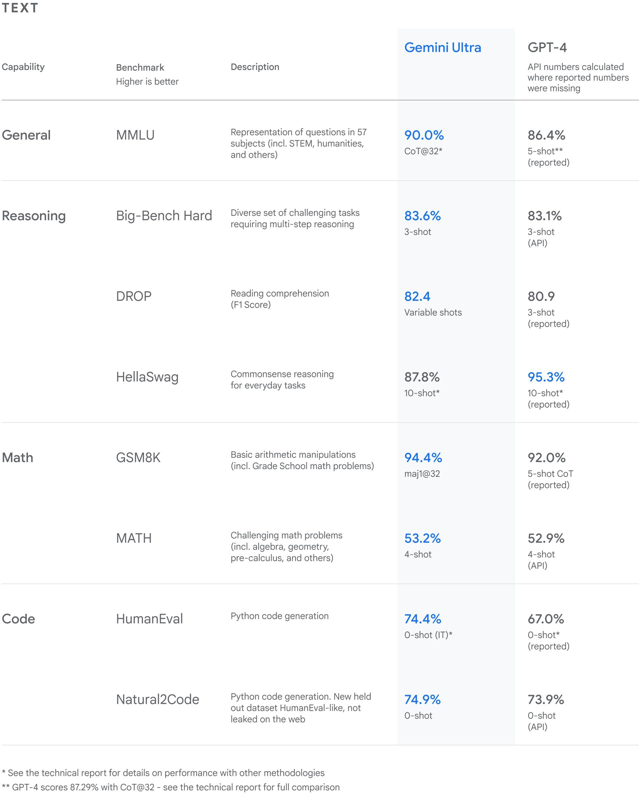

In [34]:
shrink_image(Image.open(chart_path_jpg), 3)

Now, let's see how the LLM can handle the following query.

In [35]:
prompt = """You are a tool that interprets tables. Which model (Gemini Ultra or GPT-4) is better in the 'Math' category in MATH benchmark?"""
Markdown(generate_content_from_image(prompt, [chart_path_jpg]))

In the MATH benchmark, Gemini Ultra scores 53.2% and GPT-4 scores 52.9%. Therefore, Gemini Ultra is better in the 'Math' category in the MATH benchmark.


## Extracting information from a single slide
You will use the model to extract information from a single slide. In this case graph describing pub/sub. It is not a complicated usecase, however it will showcase, how you can call the model.

You need to download an example chart.


In [36]:
image_path = "/content/GCPSketchnote/images/pubsub.jpg"

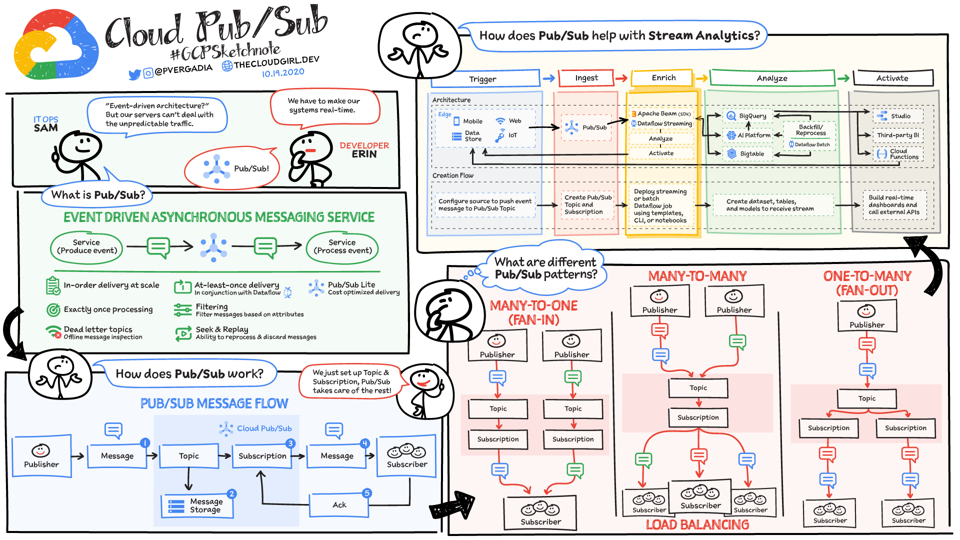

In [37]:
shrink_image(Image.open(image_path))

Start with something simple:

In [38]:
prompt = "Describe the image in 5 sentences."
response = generate_content_from_image(prompt, [image_path])
Markdown(response)

This image is a colorful, hand-drawn sketch note explaining Google Cloud's Pub/Sub service. It defines Pub/Sub as an event-driven asynchronous messaging service and illustrates how it works through a diagram showing messages flowing from a publisher to a subscriber via a topic and subscription. The sketch explores the benefits of using Pub/Sub for stream analytics, including the stages of trigger, ingest, enrich, analyze, and activate. It also showcases different Pub/Sub patterns like many-to-one (fan-in), many-to-many, and one-to-many (fan-out). The image is peppered with small, expressive stick figures that add a friendly and informative touch.

You can also use it to extract information from specific parts of the image:

In [39]:
prompt = "Explain the diffrent pub sub patters using the image. Ignore the rest."
response = generate_content_from_image(prompt, [image_path])
Markdown(response)

Okay, let's break down the Pub/Sub patterns presented in the image. The section titled "What are different Pub/Sub patterns?" shows three distinct patterns.

Here are the descriptions, based on what the image visually communicates:

1.  **MANY-TO-ONE (FAN-IN):**

    *   Multiple publishers send messages to separate topics.
    *   Each topic has one subscription.
    *   All subscriptions send data to a shared set of subscribers.
    *   **Implication:** This pattern allows multiple producers of data to feed into a single processing point or system. For instance, many devices reporting sensor data into a single analytics engine.

2.  **MANY-TO-MANY:**

    *   Multiple publishers send messages to a single topic.
    *   The topic has one subscription.
    *   The single subscription sends data to a load balanced group of subscribers.
    *   **Implication:** This pattern allows multiple producers to send data to a group of subscribers and load balancing helps to ensure even usage.

3.  **ONE-TO-MANY (FAN-OUT):**

    *   A single publisher sends messages to a single topic.
    *   The topic has multiple subscriptions.
    *   Each subscription sends data to its respective subscribers.
    *   **Implication:** This pattern allows one source of data to be distributed to multiple, independent consumers. A common use case would be a single event triggering multiple different downstream processes. For example, a user signup event might trigger a welcome email, a CRM update, and a data warehousing job.

## Slide Decks
While most models can receive only a handful images at once, The Gemini Flash model is able to receive up to 3,600 images in a single request. This means that most slide decks can be passed without any splitting to the model.

In this case you will use the LLM to create a set of questions that check the knowledge of GCP products:

In [40]:
prompt = """
  Your job is to create a set of questions to check knowledge of various
  gcp products. Write for each image the topic and example question.
"""

response = generate_content_from_image(prompt, images[:4])
Markdown(response)

Okay, here's a set of questions based on the provided images, covering different Google Cloud Platform (GCP) products and topics.

**Image 1: Compute Options (Compute Engine, Kubernetes Engine, Cloud Run, Cloud Functions)**

*   **Topic:** Choosing the right compute option
*   **Example Question:** "Your team needs to migrate an existing application that relies on specific kernel modules and requires custom OS configurations. Which compute option is the MOST suitable?"

**Image 2: Cloud Load Balancing**

*   **Topic:** Load Balancing options
*   **Example Question:** "Your application is experiencing a surge in traffic, and you need a globally distributed load balancing solution to handle both HTTP and HTTPS requests. Which type of load balancer would you choose?"

**Image 3: Data Transfer Options**

*   **Topic:** Data Transfer Services
*   **Example Question:** "You need to transfer a large on-premises data warehouse (multiple terabytes) to BigQuery in Google Cloud, but your network bandwidth is limited. Which service should you consider?"

**Image 4: Compute Options (Compute Engine, Kubernetes Engine, Cloud Run, Cloud Functions)**

*   **Topic:** Comparing and contrasting different compute options.
*   **Example Question:** "What is a key difference between Cloud Run and Cloud Functions, in terms of scaling and triggering execution?"

# Summary

The Gemini API's great capabilities in processing images such as charts, graphs, and slide decks highlights the power of multimodal LLMs. Thanks to the model's ability to read and understand these visual elements, everyone can unlock great ideas, simplify tasks, and save valuable time.

Imagine the impact of leveraging Gemini API to implement AI solutions that describe surroundings for the disabled community, making technology more inclusive and accessible to all.

This is just one of the exciting possibilities. Now, it's your turn to explore Gemini further!